In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/TacTile Segmentation AI

/content/drive/MyDrive/TacTile Segmentation AI


In [ ]:
## 데이터 전처리
from os import listdir

trainset = [[], []]
testset = [[], []]

In [ ]:
def preprocess_y(img):
  preprocess_result = []

  for i in img:
    preprocess_result.append([])
    for j in i:
      label = 0 if j[2] == 84 else 1
      preprocess_result[-1].append(label)

  preprocess_result = np.array(preprocess_result)
  return preprocess_result

In [ ]:
for x_path, y_path in zip(sorted(listdir("./dataset/yellow_dataset/trainset/x")), sorted(listdir("./dataset/yellow_dataset/trainset/y"))):
  x_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/trainset/x/" + x_path), cv2.COLOR_BGR2RGB)
  y_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/trainset/y/" + y_path), cv2.COLOR_BGR2RGB)

  preprocess_y_image = preprocess_y(y_image)

  trainset[0].append(np.transpose(x_image))
  trainset[1].append(np.array([preprocess_y_image]))

In [ ]:
train_x, train_y = np.array(trainset[0]), np.array(trainset[1])
print(train_x.shape, train_y.shape)

(300, 3, 256, 256) (300, 1, 256, 256)


In [ ]:
for x_path, y_path in zip(sorted(listdir("./dataset/yellow_dataset/testset/x")), sorted(listdir("./dataset/yellow_dataset/testset/y"))):
  x_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/testset/x/" + x_path), cv2.COLOR_BGR2RGB)
  y_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/testset/y/" + y_path), cv2.COLOR_BGR2RGB)

  preprocess_y_image = preprocess_y(y_image)

  testset[0].append(np.transpose(x_image))
  testset[1].append(np.array([preprocess_y_image]))

In [ ]:
test_x, test_y = np.array(testset[0]), np.array(testset[1])
print(test_x.shape, test_y.shape)

(50, 3, 256, 256) (50, 1, 256, 256)


In [ ]:
np.save("./yellow_train_x.npy", train_x)
np.save("./yellow_train_y.npy", train_y)
np.save("./yellow_test_x.npy", test_x)
np.save("./yellow_test_y.npy", test_y)

In [2]:
train_x = np.load("./yellow_train_x.npy")
train_y = np.load("./yellow_train_y.npy")
test_x = np.load("./yellow_test_x.npy")
test_y = np.load("./yellow_test_y.npy")

In [9]:
class YellowFCN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1)
        self.down_bn1 = nn.BatchNorm2d(3)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.down_bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1)
        self.down_bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1)
        self.down_bn4 = nn.BatchNorm2d(256)

        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn3 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn2 = nn.BatchNorm2d(16)

        self.deconv1 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn1 = nn.BatchNorm2d(3)

        self.classifier = nn.ConvTranspose2d(3, 1, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1 = self.down_bn1(conv1)

        conv2 = self.conv2(bn1)
        bn2 = self.down_bn2(conv2)

        conv3 = self.conv3(bn2)
        bn3 = self.down_bn3(conv3)

        conv4 = self.conv4(bn3)
        bn4 = self.down_bn4(conv4)

        out = self.deconv3(bn4)
        out = self.up_bn3(out)

        out = self.deconv2(out + bn3)
        out = self.up_bn2(out)

        out = self.deconv1(out + bn2)
        out = self.up_bn1(out)

        out = self.classifier(out)

        return out

In [10]:
summary(YellowFCN().cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              84
       BatchNorm2d-2          [-1, 3, 128, 128]               6
            Conv2d-3           [-1, 16, 64, 64]             448
       BatchNorm2d-4           [-1, 16, 64, 64]              32
            Conv2d-5           [-1, 64, 32, 32]           9,280
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 16, 16]         147,712
       BatchNorm2d-8          [-1, 256, 16, 16]             512
   ConvTranspose2d-9           [-1, 64, 32, 32]         147,520
      BatchNorm2d-10           [-1, 64, 32, 32]             128
  ConvTranspose2d-11           [-1, 16, 64, 64]           9,232
      BatchNorm2d-12           [-1, 16, 64, 64]              32
  ConvTranspose2d-13          [-1, 3, 128, 128]             435
      BatchNorm2d-14          [-1, 3, 1

In [12]:
train_set = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
trainloader = DataLoader(train_set, batch_size=100, shuffle=True)

In [13]:
model = YellowFCN().cuda()
criterion = nn.BCELoss().cuda()
optimizer = Adam(model.parameters(), lr=0.002)

In [14]:
val_set_x = torch.from_numpy(test_x[:25]).float().cuda()
val_set_y = torch.from_numpy(test_y[:25]).float().cuda()
val_criterion = nn.BCELoss().cuda()

def get_val_loss(val_model):
    pred = val_model(val_set_x)
    pred = nn.functional.sigmoid(pred)
    val_loss = val_criterion(pred, val_set_y)
    
    val_loss /= 100

    return val_loss

In [15]:
avg_loss_log = []
val_loss_log = []

for epoch in range(10):
    avg_loss = 0

    for x, y in trainloader:
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()
        pred = model(x)
        pred = nn.functional.sigmoid(pred)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        avg_loss += loss

    avg_loss /= 300
    validation_loss = get_val_loss(model)
    
#     avg_loss_log.append(avg_loss)
#     val_loss_log.append(validation_loss)

    print(f"epoch: {epoch}, avg_loss: {avg_loss}, val_loss: {validation_loss}")

c:\users\simplepro\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, avg_loss: 0.02058120258152485, val_loss: 0.005757532082498074
epoch: 1, avg_loss: 0.01832767017185688, val_loss: 0.005196671932935715
epoch: 2, avg_loss: 0.016572199761867523, val_loss: 0.004704194609075785
epoch: 3, avg_loss: 0.015021182596683502, val_loss: 0.00426681712269783
epoch: 4, avg_loss: 0.013648878782987595, val_loss: 0.003874033223837614
epoch: 5, avg_loss: 0.01240017730742693, val_loss: 0.003521100152283907
epoch: 6, avg_loss: 0.01127627119421959, val_loss: 0.003204034175723791
epoch: 7, avg_loss: 0.010272516869008541, val_loss: 0.002919543534517288
epoch: 8, avg_loss: 0.009376192465424538, val_loss: 0.002664686180651188
epoch: 9, avg_loss: 0.008552388288080692, val_loss: 0.002434638561680913


In [28]:
pred = nn.functional.sigmoid(model(torch.Tensor(test_x[100:110]).float().cuda())).cpu().detach().numpy()
print(pred.shape)

(10, 1, 256, 256)


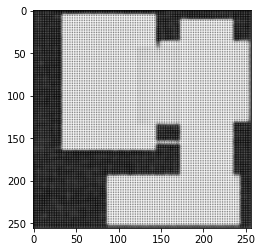

In [36]:
plt.imshow(np.transpose(pred[1][0]), cmap="gray")

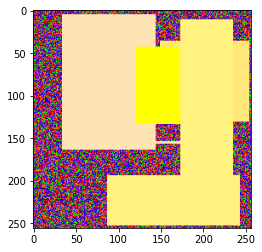

In [35]:
plt.imshow(np.transpose(test_x[101]))